In [1]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

In [2]:
flight_data = pd.read_csv('./dataset/merged_data/latter_flight_data.csv')
flight_data.head()
flight_data.shape

,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,OP_UNIQUE_CARRIER,ORIGIN,ARR_DELAY,SCH_DEP_TIME,SCH_ARR_TIME,ORGIN_WTH_temp,ORGIN_WTH_precip,ORGIN_WTH_precipprob,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,ORGIN_WTH_severerisk,DEST_WTH_temp,DEST_WTH_precip,DEST_WTH_precipprob,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DEST_WTH_severerisk,FORMER_FLIGHT_STATUS
0,6,WN,WN,MCO,-26.00,2022-01-01 10:30:00,2022-01-01 13:20:00,74.00,0.00,0,0.00,6.90,200.00,2.90,9.90,3.00,48.00,0.00,0,0.00,3.60,8.00,100.00,9.80,3.00,NaN
1,6,UA,OO,ORD,-25.00,2022-01-01 10:40:00,2022-01-01 13:32:00,36.10,0.00,0,0.02,21.00,20.00,100.00,9.90,3.00,47.90,0.00,0,0.00,0.40,358.00,100.00,9.70,3.00,NaN
2,6,B6,B6,MCO,22.00,2022-01-01 13:13:00,2022-01-01 15:56:00,83.00,0.00,0,0.00,9.90,199.00,4.30,9.90,3.00,47.70,0.00,0,0.00,7.90,311.00,100.00,7.80,3.00,early
3,6,B6,B6,JFK,36.00,2022-01-01 21:45:00,2022-01-01 22:59:00,52.80,0.15,100,0.00,8.10,40.00,100.00,2.20,3.00,37.90,0.02,100,0.00,6.10,303.00,100.00,6.80,3.00,NaN
4,7,B6,B6,JFK,-12.00,2022-01-02 08:29:00,2022-01-02 09:50:00,52.10,0.00,0,0.00,0.00,0.00,100.00,5.90,3.00,25.00,0.00,0,0.01,13.80,303.00,100.00,1.20,3.00,NaN


(6773, 26)

In [3]:
# Drop NaN for latter flight data
if True:
    flight_data.dropna(subset=['FORMER_FLIGHT_STATUS'], inplace=True)

In [4]:
X = flight_data.drop(columns=['ARR_DELAY'])
y = flight_data['ARR_DELAY']

In [5]:
potential_categorical_vars = {}
# For categorical variables if we are considering variables which were coded to integers, but are actually catagorical.
if True:
    for col in flight_data.columns:
        unique_col_vals = flight_data[col].unique()
        if(len(unique_col_vals) < 15):
            potential_categorical_vars[col] = unique_col_vals
potential_categorical_vars

{'DAY_OF_WEEK': array([6, 7, 1, 2, 3, 4, 5]),
 'MKT_UNIQUE_CARRIER': array(['B6', 'UA', 'DL', 'AA', 'WN'], dtype=object),
 'OP_UNIQUE_CARRIER': array(['B6', 'OO', '9E', 'MQ', 'G7', 'PT', 'YX', 'UA', 'WN', 'ZW'],
       dtype=object),
 'ORIGIN': array(['MCO', 'ORD', 'JFK'], dtype=object),
 'ORGIN_WTH_precipprob': array([  0, 100]),
 'ORGIN_WTH_severerisk': array([  3.,  10.,  30.,   5.,  15.,  60., 100.,   8.,  50.,  19.,  25.,
         75.,  38.]),
 'DEST_WTH_precipprob': array([  0, 100]),
 'DEST_WTH_severerisk': array([  3.,  10.,  30.,  60.,   5.,  75., 100.,   8.]),
 'FORMER_FLIGHT_STATUS': array(['early', 'late', 'on-time'], dtype=object)}

In [6]:
# Handle Categorical Variables
categorical_vars = ['DAY_OF_WEEK', 'MKT_UNIQUE_CARRIER',
                    'OP_UNIQUE_CARRIER', 'ORIGIN',
                    'ORGIN_WTH_precipprob', 'ORGIN_WTH_severerisk',
                    'DEST_WTH_precipprob', 'DEST_WTH_severerisk',
                    'FORMER_FLIGHT_STATUS', 'MONTH']

# categorical_vars = potential_categorical_vars.keys()

In [7]:
def preprocess(flight_data: pd.DataFrame):

    # Dealing with date and time
    flight_data['SCH_ARR_TIME'] = pd.to_datetime(flight_data['SCH_ARR_TIME'])
    flight_data['SCH_DEP_TIME'] = pd.to_datetime(flight_data['SCH_DEP_TIME'])

    flight_data['MONTH'] = flight_data['SCH_ARR_TIME'].dt.month
    flight_data['DAY'] = flight_data['SCH_ARR_TIME'].dt.day
    flight_data['DEP_MINUTES'] = flight_data['SCH_DEP_TIME'].dt.hour * 60 + flight_data['SCH_DEP_TIME'].dt.minute
    flight_data['ARR_MINUTES'] = flight_data['SCH_ARR_TIME'].dt.hour * 60 + flight_data['SCH_ARR_TIME'].dt.minute

    flight_data.drop(columns=['SCH_DEP_TIME', 'SCH_ARR_TIME'], inplace=True)

    # Dropping unwanted columns
    cols = [
        'ORGIN_WTH_temp', 'DEST_WTH_temp',
        'DEST_WTH_severerisk', 'ORGIN_WTH_severerisk',
        'DEST_WTH_precipprob', 'ORGIN_WTH_precipprob'
        ]
    flight_data.drop(columns=cols, inplace=True)
    
    cat_col = list(set(flight_data.columns).intersection(categorical_vars))
    flight_data = pd.get_dummies(flight_data, columns = list(cat_col), drop_first = False)

    return flight_data
    

In [8]:
X = preprocess(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 35)

X_train.head()
X_test.head()
y_train.head()
y_test.head()


,ORGIN_WTH_precip,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,DEST_WTH_precip,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DAY,DEP_MINUTES,ARR_MINUTES,FORMER_FLIGHT_STATUS_early,FORMER_FLIGHT_STATUS_late,FORMER_FLIGHT_STATUS_on-time,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_G7,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_PT,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,OP_UNIQUE_CARRIER_YX,OP_UNIQUE_CARRIER_ZW,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,ORIGIN_JFK,ORIGIN_MCO,ORIGIN_ORD,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,MKT_UNIQUE_CARRIER_AA,MKT_UNIQUE_CARRIER_B6,MKT_UNIQUE_CARRIER_DL,MKT_UNIQUE_CARRIER_UA,MKT_UNIQUE_CARRIER_WN
1460,0.00,0.00,13.90,290.00,47.30,9.90,0.00,0.00,20.50,280.00,89.60,9.90,9,910,1081,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False
3395,0.00,0.00,1.60,27.00,23.80,9.90,0.00,0.00,4.60,70.00,48.30,9.90,8,980,1068,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False
4434,0.00,0.00,16.50,295.00,90.30,9.90,0.00,0.00,0.50,355.00,86.70,9.90,24,827,996,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False
5136,0.00,0.00,8.40,140.00,78.40,9.90,0.00,0.00,0.00,1.00,26.90,9.90,13,1116,1292,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False
5504,0.00,0.00,9.60,252.00,24.20,7.80,0.00,0.00,13.60,140.00,100.00,8.80,24,495,667,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False


,ORGIN_WTH_precip,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,DEST_WTH_precip,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DAY,DEP_MINUTES,ARR_MINUTES,FORMER_FLIGHT_STATUS_early,FORMER_FLIGHT_STATUS_late,FORMER_FLIGHT_STATUS_on-time,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_G7,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_PT,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,OP_UNIQUE_CARRIER_YX,OP_UNIQUE_CARRIER_ZW,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,ORIGIN_JFK,ORIGIN_MCO,ORIGIN_ORD,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,MKT_UNIQUE_CARRIER_AA,MKT_UNIQUE_CARRIER_B6,MKT_UNIQUE_CARRIER_DL,MKT_UNIQUE_CARRIER_UA,MKT_UNIQUE_CARRIER_WN
158,0.00,0.08,9.20,315.00,100.00,2.60,0.00,0.00,9.30,280.00,88.80,9.80,20,750,825,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
1891,0.00,0.00,6.90,353.00,76.30,9.90,0.00,0.00,12.70,319.00,48.80,9.90,12,835,1010,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False
73,0.00,0.00,13.60,304.00,0.00,9.90,0.00,0.04,19.70,240.00,28.70,9.60,10,760,931,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False
496,0.00,0.00,6.00,292.00,0.80,9.90,0.00,0.05,0.20,354.00,50.60,9.90,2,750,825,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3408,0.00,0.00,8.70,191.00,88.10,9.90,0.00,0.00,15.80,251.00,100.00,5.00,9,1104,1277,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False


1460   -17.00
3395    -9.00
4434    -1.00
5136    17.00
5504    20.00
Name: ARR_DELAY, dtype: float64

158      9.00
1891   -11.00
73     -13.00
496    -14.00
3408   -16.00
Name: ARR_DELAY, dtype: float64

In [10]:
def sMAPE_metric(actual_values, predicted_values):
    actual_predicted_absolute_sum = np.abs(actual_values) + np.abs(predicted_values)
    actual_predicted_absolute_diff = np.abs(actual_values - predicted_values)
    sMAPE = np.mean(actual_predicted_absolute_diff / actual_predicted_absolute_sum)
    return sMAPE

In [11]:
gb = GradientBoostingRegressor(random_state=50, min_samples_leaf = 2, min_samples_split = 6, max_depth = 5)

gb = gb.fit(X_train, y_train) 
test_output_gb = pd.DataFrame(gb.predict(X_test), index = X_test.index, columns = ['pred_ARR_DELAY'])
test_output_gb = test_output_gb.merge(y_test, left_index = True, right_index = True)
test_output_gb.head()
mean_absolute_error_gb = abs(test_output_gb['pred_ARR_DELAY'] - test_output_gb['ARR_DELAY']).mean()
print(f"GradientBoostingRegressor mean absolute error is: {mean_absolute_error_gb:.2f}")
print(f"GradientBoostingRegressor error ratio: {abs(test_output_gb['pred_ARR_DELAY'] - test_output_gb['ARR_DELAY']).mean()/test_output_gb['ARR_DELAY'].mean():.2f}")
test_output_gb['ARR_DELAY'].mean()

,pred_ARR_DELAY,ARR_DELAY
158,25.05,9.00
1891,2.49,-11.00
73,4.28,-13.00
496,11.30,-14.00
3408,8.11,-16.00


GradientBoostingRegressor mean absolute error is: 24.16
GradientBoostingRegressor error ratio: 3.24


7.450897571277719

In [12]:
print(f"sMAPE for GradientBoostingRegressor model: {sMAPE_metric(test_output_gb['pred_ARR_DELAY'], test_output_gb['ARR_DELAY']) * 100:.2f}")

sMAPE for GradientBoostingRegressor model: 72.28


## Trying classification

In [13]:
def categorize_delay(delay):
    if delay < -5:
        return 0 #early
    elif delay > 5:
        return 2 #late
    else:
        return 1 #ontime

In [14]:
y = flight_data['ARR_DELAY'].apply(categorize_delay)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state = 21)


In [16]:
def lineplot(learning_rate_range, train, test, title):
    plt.plot(learning_rate_range, test, c='m', label='Test')
    plt.plot(learning_rate_range, train, c='orange', label='Train')
    plt.xlabel('Learning rate')
    plt.xticks(learning_rate_range)
    plt.ylabel('Accuracy score')
    plt.ylim(0.5, 1)
    plt.legend(prop={'size': 12}, loc=3)
    plt.title(title, size=14)

#### xgBoost

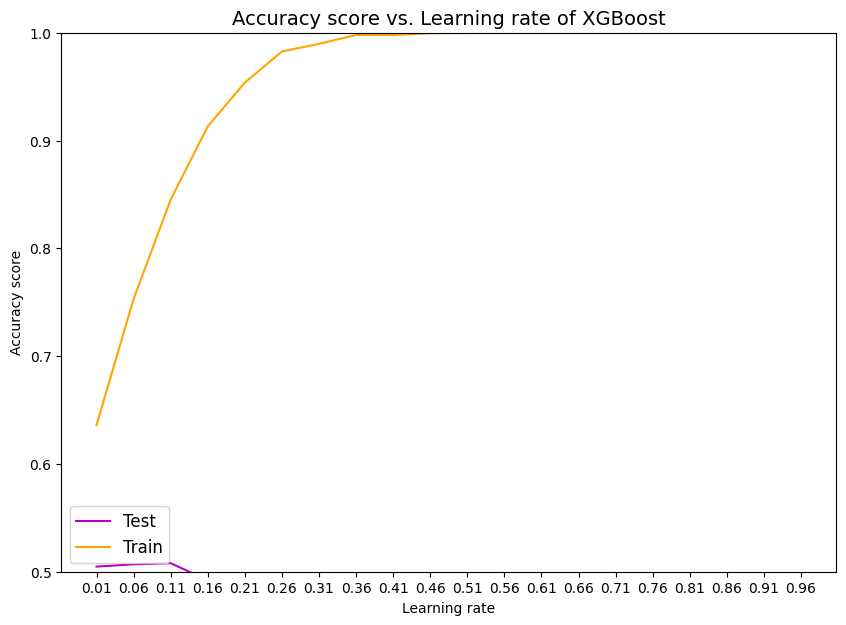

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

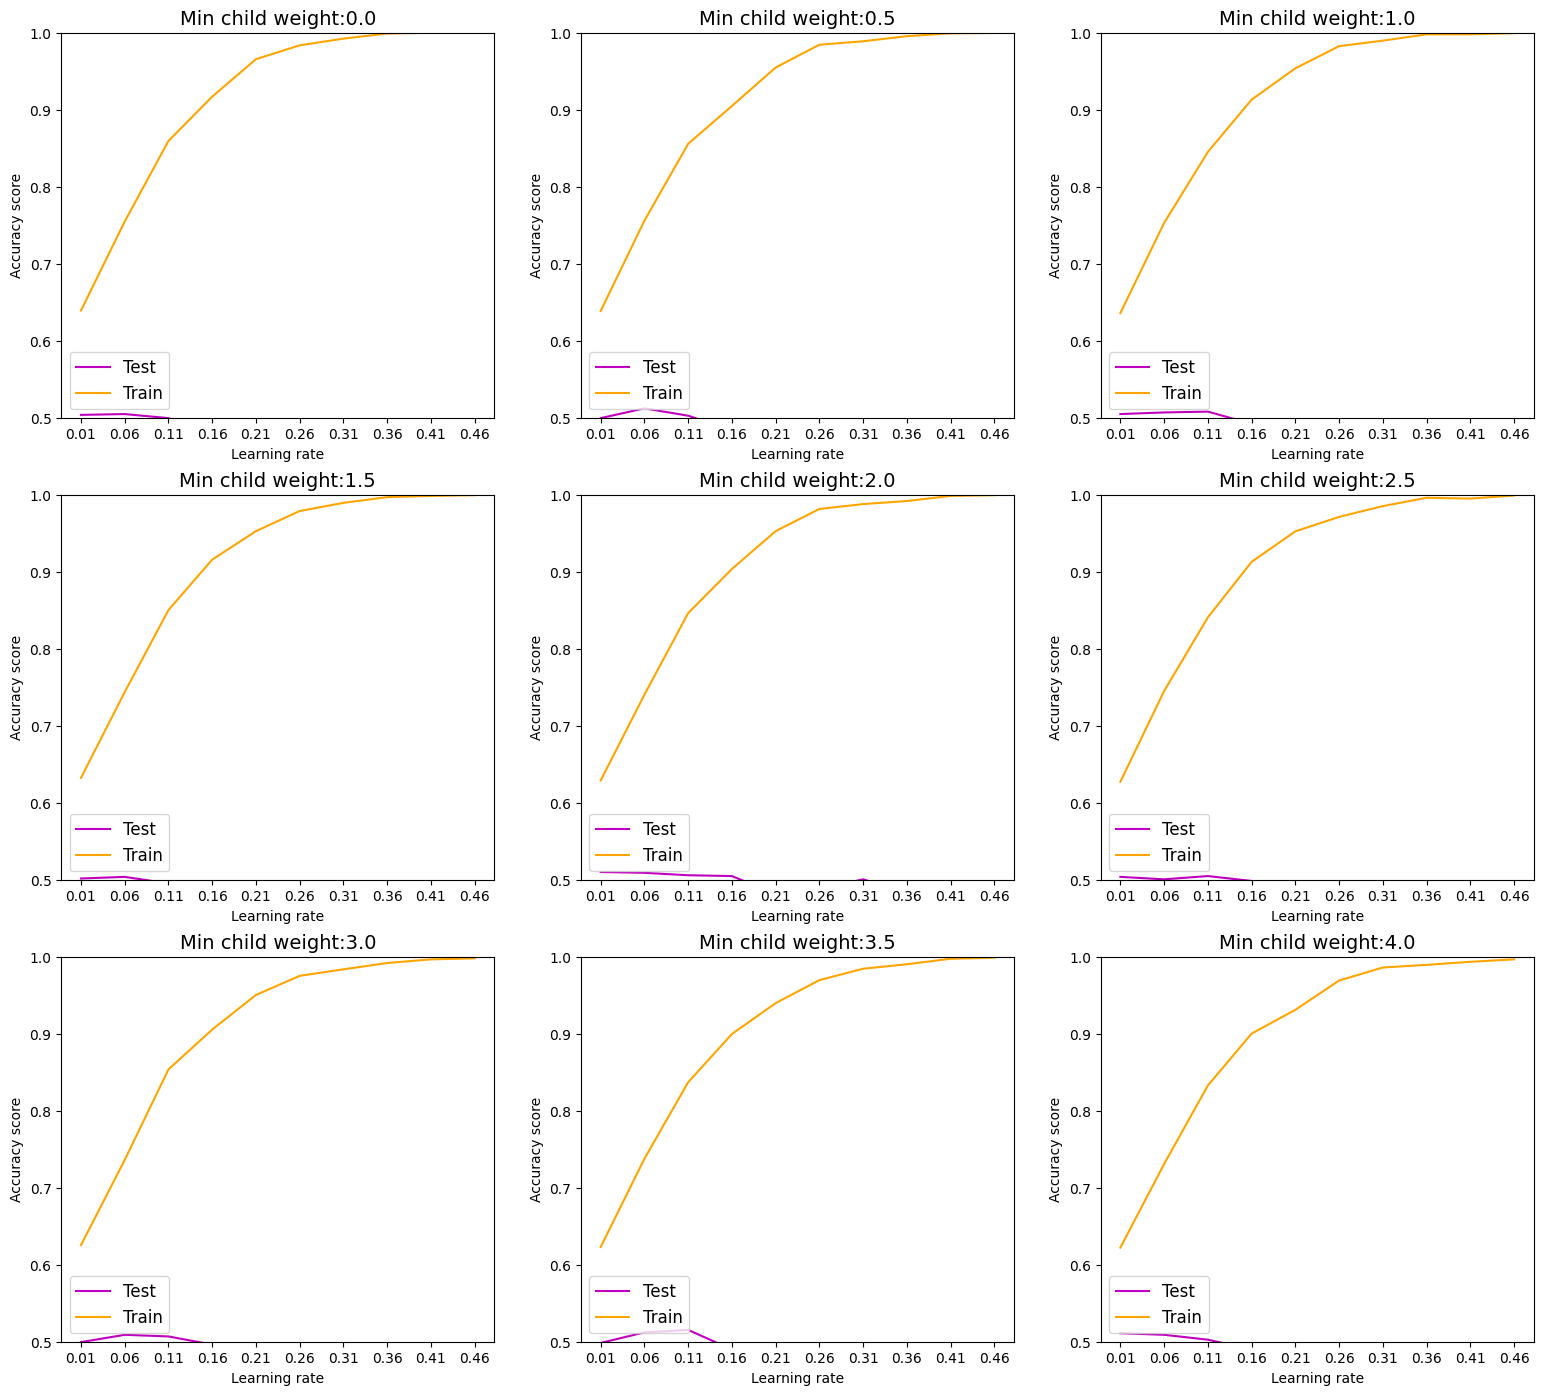

In [17]:
if False:
    # XGBoost (different learning rate)
    learning_rate_range = np.arange(0.01, 1, 0.05)
    test = [] 
    train = []
    for lr in learning_rate_range:
        xgb_classifier = xgb.XGBClassifier(eta = lr)
        _ =xgb_classifier.fit(X_train, y_train)
        train.append(xgb_classifier.score(X_train, y_train))
        test.append(xgb_classifier.score(X_test, y_test))
    # Line plot
    fig = plt.figure(figsize=(10, 7))
    lineplot(learning_rate_range, train, test, title='Accuracy score vs. Learning rate of XGBoost')
    plt.show()

    # Resolve overfitting 
    # new learning rate range
    learning_rate_range = np.arange(0.01, 0.5, 0.05)
    fig = plt.figure(figsize=(19, 17))
    idx = 1
    # grid search for min_child_weight
    for weight in np.arange(0, 4.5, 0.5):
        train = []
        test = []
        for lr in learning_rate_range:
            xgb_classifier = xgb.XGBClassifier(eta = lr, reg_lambda=1, min_child_weight=weight)
            _ = xgb_classifier.fit(X_train, y_train)
            train.append(xgb_classifier.score(X_train, y_train))
            test.append(xgb_classifier.score(X_test, y_test))
        fig.add_subplot(3, 3, idx)
        idx += 1
        title = "Min child weight:" + str(weight)
        lineplot(learning_rate_range, train ,test, title)
    plt.show()

In [18]:
xg_model = xgb.XGBClassifier(eta = '0.08', max_depth=5, min_child_weight=1, reg_lambda=0.007)
xg_model = xg_model.fit(X_train, y_train) 
xg_model.score(X_train, y_train) 

# gb.feature_importances_
feat_imp = pd.Series(xg_model.feature_importances_, X_train.columns.values).sort_values(ascending=False)

feat_imp_table = pd.DataFrame(feat_imp)
feat_imp_table = feat_imp_table.reset_index()
feat_imp_table.columns = ['Features', 'Values']
feat_imp.head(20)

test_output = pd.DataFrame(xg_model.predict(X_test), index = X_test.index, columns = ['pred_Y'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
print('Fraction of correct classification ')
xg_model.score(X_test, y_test) 
test_output['pred_Y'].value_counts()

0.7223249669749009

MKT_UNIQUE_CARRIER_DL        0.08
OP_UNIQUE_CARRIER_B6         0.06
ORIGIN_ORD                   0.05
ORGIN_WTH_snow               0.03
ORGIN_WTH_visibility         0.03
MONTH_5                      0.02
FORMER_FLIGHT_STATUS_early   0.02
MONTH_1                      0.02
ARR_MINUTES                  0.02
ORIGIN_JFK                   0.02
MONTH_7                      0.02
MONTH_11                     0.02
OP_UNIQUE_CARRIER_UA         0.02
OP_UNIQUE_CARRIER_OO         0.02
OP_UNIQUE_CARRIER_MQ         0.02
DEP_MINUTES                  0.02
MONTH_10                     0.02
ORGIN_WTH_precip             0.02
DAY_OF_WEEK_5                0.02
DAY_OF_WEEK_3                0.02
dtype: float32

,pred_Y,ARR_DELAY
1071,0,0
4322,0,2
6207,0,2
2626,0,0
154,0,1


Fraction of correct classification 


0.49947201689545934

pred_Y
0    678
2    220
1     49
Name: count, dtype: int64

#### GradientBoosting

In [19]:
gb = GradientBoostingClassifier(random_state=50, min_samples_split = 2, min_samples_leaf = 6, max_depth = 7, n_estimators = 200)
gb = gb.fit(X_train, y_train) 
gb.score(X_train, y_train) 

# gb.feature_importances_
feat_imp = pd.Series(gb.feature_importances_, X_train.columns.values).sort_values(ascending=False)

feat_imp_table = pd.DataFrame(feat_imp)
feat_imp_table = feat_imp_table.reset_index()
feat_imp_table.columns = ['Features', 'Values']
feat_imp.head(20)

test_output = pd.DataFrame(gb.predict(X_test), index = X_test.index, columns = ['pred_Y'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
print('Fraction of correct classification ')
gb.score(X_test, y_test) 
test_output['pred_Y'].value_counts()

0.9997357992073976

ORGIN_WTH_winddir            0.11
ORGIN_WTH_windspeed          0.10
DEST_WTH_winddir             0.10
DEST_WTH_windspeed           0.08
ARR_MINUTES                  0.07
DAY                          0.07
ORGIN_WTH_cloudcover         0.06
DEP_MINUTES                  0.06
DEST_WTH_cloudcover          0.06
ORGIN_WTH_visibility         0.03
DEST_WTH_visibility          0.02
DEST_WTH_precip              0.02
MKT_UNIQUE_CARRIER_DL        0.01
ORGIN_WTH_precip             0.01
FORMER_FLIGHT_STATUS_early   0.01
FORMER_FLIGHT_STATUS_late    0.01
DAY_OF_WEEK_3                0.01
MKT_UNIQUE_CARRIER_B6        0.01
OP_UNIQUE_CARRIER_B6         0.01
ORGIN_WTH_snow               0.01
dtype: float64

,pred_Y,ARR_DELAY
1071,0,0
4322,0,2
6207,0,2
2626,0,0
154,0,1


Fraction of correct classification 


0.46884899683210135

pred_Y
0    581
2    268
1     98
Name: count, dtype: int64

##### Random Forest

In [20]:
rf = RandomForestClassifier(max_features='sqrt', min_samples_leaf=4)
rf = rf.fit(X_train, y_train)
rf.score(X_train, y_train)

feat_imp = pd.Series(rf.feature_importances_, X_train.columns.values).sort_values(ascending=False)
feat_imp.head(20)

test_output = pd.DataFrame(rf.predict(X_test), index = X_test.index, columns = ['pred_Y'])

test_output.head()
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
print('Fraction of correct classification ')
rf.score(X_test, y_test) 
test_output['pred_Y'].value_counts()

0.823778071334214

ORGIN_WTH_windspeed            0.08
ORGIN_WTH_winddir              0.08
DEST_WTH_winddir               0.08
ARR_MINUTES                    0.07
DEP_MINUTES                    0.07
DEST_WTH_windspeed             0.07
DAY                            0.06
ORGIN_WTH_cloudcover           0.06
DEST_WTH_cloudcover            0.06
ORGIN_WTH_visibility           0.03
DEST_WTH_visibility            0.03
ORGIN_WTH_precip               0.02
DEST_WTH_precip                0.02
FORMER_FLIGHT_STATUS_early     0.02
OP_UNIQUE_CARRIER_B6           0.02
FORMER_FLIGHT_STATUS_late      0.01
MKT_UNIQUE_CARRIER_DL          0.01
MKT_UNIQUE_CARRIER_B6          0.01
FORMER_FLIGHT_STATUS_on-time   0.01
OP_UNIQUE_CARRIER_9E           0.01
dtype: float64

,pred_Y
1071,0
4322,0
6207,0
2626,0
154,0


,pred_Y,ARR_DELAY
1071,0,0
4322,0,2
6207,0,2
2626,0,0
154,0,1


Fraction of correct classification 


0.5195353748680043

pred_Y
0    696
2    235
1     16
Name: count, dtype: int64